# L0 data clean

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import imp
import datetime
import pytz

In [128]:
#input path of new file to clean
#time period should overlap with that of previous file; no gaps.
Glacier= 'Wolverine'
Station= '990'
file= "wolverine990_2017_0911.txt"
folder=r"Q:\Project Data\GlacierData\Benchmark_Program\Data\Wolverine\2017\Wx"
pth=os.path.join(folder, file)
out_date_format='%Y/%m/%d %H:%M'

In [129]:
if Glacier + Station== r'Wolverine990':
    header_rws=2 #number of header rows to not read in
    col_nms=["Date", "Time", "Instrument", "Value", "Unit", "Flag"]
    
if Glacier + Station==r'wolverine1420':
    header_rws=4 #number of header rows to not read in
    #Grab correct column names (a few rows up in Campbell Logger output)
    coltable=pd.read_csv(pth, header=1)
    col_nms=coltable.columns

In [130]:
#Read in data
dat=pd.read_csv(pth, header=header_rws)
dat.columns= col_nms #Name columns

In [131]:
#Set constants
date_format='%m/%d/%Y %H:%M:%S'
timezone='America/Anchorage' #choose from pytz.all_timezones

In [132]:
dat.head()

,Date,Time,Instrument,Value,Unit,Flag
0,10/01/2016,00:00:00,WD,140.0000,degrees,G
1,10/01/2016,00:00:00,WS,0.7000,m/s,G
2,10/01/2016,00:00:00,BV,12.9000,V,G
3,10/01/2016,00:00:00,Tinternal,3.8000,C,G
4,10/01/2016,00:00:00,PC,0.2258,m,G


In [133]:
for col in list(dat):
    print ("stripping whitespace from " + col) #print column name    
    if type(dat[col].values[0]).__name__ =='str': #if column is a string, strip white space
        dat[col]=dat[col].str.strip()

stripping whitespace from Date
stripping whitespace from Time
stripping whitespace from Instrument
stripping whitespace from Value
stripping whitespace from Unit
stripping whitespace from Flag


In [134]:
#Fix time
#Create date-time column
dat['time']=dat.Date+ " " + dat.Time
dat.loc[:,'time']=pd.to_datetime(dat['time'], format=date_format) #set to date-time from string
#Correct for time slips
dat['time']=dat['time'].dt.round('15min') #round time to the nearest 15 minute value
#Convert to UTC time
dat['UTC_col']=dat.time + datetime.timedelta(hours=8)
dat['UTC_col'].timezone='UTC'
#Create column for local time
local_timezone=pytz.timezone(timezone) #create local timezone object (e.g. AK time)

In [135]:
dat=dat.set_index('UTC_col')
#Create column for local time
local_timezone=pytz.timezone(timezone) #create local timezone object (e.g. AK time)

In [136]:
#Create local time
dat['local_time'] = dat.index.tz_localize('UTC').tz_convert(local_timezone)

In [137]:
dat['index_local_time']=dat.local_time.copy()

In [138]:
#Set index to local time
dat=dat.set_index('index_local_time')

In [139]:
dat.head()

,Date,Time,Instrument,Value,Unit,Flag,time,local_time
index_local_time,,,,,,,,
2016-10-01 00:00:00-08:00,10/01/2016,00:00:00,WD,140.0000,degrees,G,2016-10-01,2016-10-01 00:00:00-08:00
2016-10-01 00:00:00-08:00,10/01/2016,00:00:00,WS,0.7000,m/s,G,2016-10-01,2016-10-01 00:00:00-08:00
2016-10-01 00:00:00-08:00,10/01/2016,00:00:00,BV,12.9000,V,G,2016-10-01,2016-10-01 00:00:00-08:00
2016-10-01 00:00:00-08:00,10/01/2016,00:00:00,Tinternal,3.8000,C,G,2016-10-01,2016-10-01 00:00:00-08:00
2016-10-01 00:00:00-08:00,10/01/2016,00:00:00,PC,0.2258,m,G,2016-10-01,2016-10-01 00:00:00-08:00


In [140]:
#In the uncommon instance that a sensor has duplicate values at a single timestep, set sensor name and value to NAN
# - this occurs occasionally during maintenance, as sensors are being renamed and added
for ii in dat.local_time.unique():
    testdat=dat[ii:ii]
    if len(testdat[testdat.Instrument.duplicated()])>0:
        duplicate_sensor_name=testdat.loc[testdat.Instrument.duplicated(), 'Instrument'][0]
        print(duplicate_sensor_name + " is being set to NAN at " + str(ii))
        dat.loc[(dat.Instrument==duplicate_sensor_name) & (dat.index==ii), 'Instrument']=np.nan
        dat.loc[(dat.Instrument==duplicate_sensor_name) & (dat.index==ii), 'Value']=np.nan

WD is being set to NAN at 2016-12-31 17:15:00-09:00
B is being set to NAN at 2017-04-28 14:45:00-08:00


In [141]:
#Cast the data from long -> wide format
dat=dat.reset_index() #reset index so all unique
wide_dat=dat.pivot_table(columns='Instrument', values='Value', index='local_time')

In [142]:
wide_dat.head()

Instrument,AT,AT2,B,BV,PC,RH,T,Tinternal,WD,WS,WSG
local_time,,,,,,,,,,,
2016-10-01 00:00:00-08:00,5.99,5.9,NaN,12.9,0.2258,26.0,NaN,3.8,140.0,0.7,NaN
2016-10-01 00:15:00-08:00,5.82,6.0,NaN,12.9,0.2258,28.0,23.3,3.5,311.0,0.5,1.5
2016-10-01 00:30:00-08:00,5.58,5.8,NaN,12.9,0.2258,26.0,22.9,3.5,225.0,1.3,1.9
2016-10-01 00:45:00-08:00,5.85,6.0,NaN,12.9,0.2258,27.0,23.1,3.2,240.0,1.3,2.1
2016-10-01 01:00:00-08:00,4.99,5.1,NaN,12.9,0.2258,32.0,22.6,3.2,240.0,1.4,1.9


In [143]:
#Rename columns to match Shad's processing
new_cols=['TAspirated1','TAspirated2','AtmPressure',
           'LoggerBattery', 'TPGCumulative', 'RelHum',
          'Tpassive1', 'LoggerTemp',
          'WindDir', 'WindSpeed',  'WindGustSpeed']

In [144]:
wide_dat.columns=new_cols

In [145]:
out_columns=['Station', 'UTC_time', 'AK_time', 'Tpassive1', 'Tpassive2',
       'TAspirated1', 'TAspirated2', 'RelHum', 'StageCumulative',
       'TPGCumulative', 'WindSpeed', 'WindGustSpeed', 'WindDir', 'LoggerTemp',
       'LoggerBattery']

In [146]:
for col in out_columns:
    if col not in wide_dat.columns:
        wide_dat[col]=np.nan #create the column; fill with NANs

In [147]:
wide_dat['UTC_time']=wide_dat.index.tz_convert('UTC').strftime(out_date_format)#Create column for true local time (as string, not UTC - X hrs)

In [148]:
wide_dat['AK_time']=wide_dat.index.tz_convert('America/Anchorage').strftime(out_date_format)#Create column for true local time (as string, not UTC - X hrs)

In [149]:
wide_dat=wide_dat.reset_index()

In [150]:
save_dat=wide_dat[out_columns]

In [151]:
#directory to save output data
save_pth=r"Q:/Project Data/GlacierData/Benchmark_Program/Data/" +Glacier+ r"/AllYears/Wx/LVL0/emily/"

In [152]:
out_nm=Glacier.lower()+ Station + '_2017_15minL0.csv'

In [153]:
save_dat.to_csv(os.path.join(save_pth, out_nm), index=False)

<IPython.core.display.Javascript object>


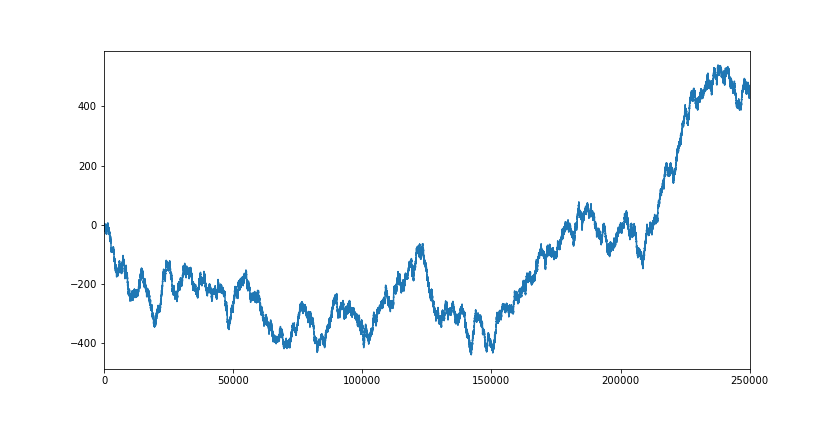

In [62]:
%matplotlib notebook
vals.plot()

In [122]:
#Original values in cumulative series
vals=pd.Series(range(0,100))

#Calculate incremental change
incremental_vals=vals-vals.shift(1) #calculate incremental changes

#Calculate cumulative sum of incremental values
new_cumulative=incremental_vals.cumsum()
new_cumulative[0]=vals[0] #set first value of new cumulative series to equal iniitial value; NAN introduced

#Check if new series equals original
vals.equals(new_cumulative)

False

In [123]:
compare_df=pd.concat([vals, incremental_vals, new_cumulative], axis=1)
compare_df.columns=['original values', 'incremental difference values', 'new cumulative']

In [125]:
compare_df

,original values,incremental difference values,new cumulative
0,0,NaN,0.0
1,1,1.0,1.0
2,2,1.0,2.0
3,3,1.0,3.0
4,4,1.0,4.0
5,5,1.0,5.0
6,6,1.0,6.0
7,7,1.0,7.0
8,8,1.0,8.0
9,9,1.0,9.0


<IPython.core.display.Javascript object>


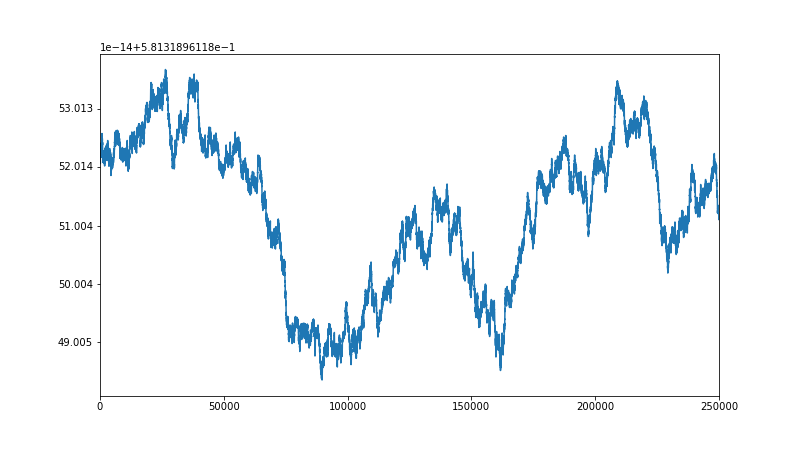

In [39]:
%matplotlib notebook
WTF.plot()